# Análise das Metabases

In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openml


In [2]:
METABASE_PATH = '../../scripts/metabase/'

## Análise de Bases

In [3]:
dataset_ids = !ls $METABASE_PATH
len(dataset_ids)

100

In [4]:
openml_datasets = openml.datasets.list_datasets(output_format='dataframe')

In [5]:
selected_datasets = openml_datasets.loc[[int(did) for did in dataset_ids]]

In [6]:
selected_datasets.describe()

,did,version,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
count,100.000000,100.000000,100.000000,55.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.000000,100.000000
mean,24942.370000,1.700000,920.730000,5.090909,513.610000,2.370000,30.080000,1553.570000,0.0,0.0,21.250000,8.820000
std,21445.674333,1.623688,999.162668,7.029759,780.052483,0.848707,34.716945,1638.784862,0.0,0.0,26.470252,26.876966
min,40.000000,1.000000,48.000000,2.000000,5.000000,2.000000,3.000000,100.000000,0.0,0.0,0.000000,1.000000
25%,914.500000,1.000000,195.750000,2.000000,77.750000,2.000000,7.000000,310.000000,0.0,0.0,4.000000,1.000000
50%,40940.500000,1.000000,598.000000,2.000000,199.000000,2.000000,21.000000,1415.000000,0.0,0.0,10.500000,1.000000
75%,44498.500000,2.000000,1085.500000,4.500000,635.250000,2.000000,37.250000,2000.000000,0.0,0.0,25.250000,6.250000
max,45553.000000,12.000000,5136.000000,43.000000,4735.000000,5.000000,241.000000,9871.000000,0.0,0.0,100.000000,241.000000


<Axes: title={'center': 'Número de classes'}, ylabel='Frequency'>

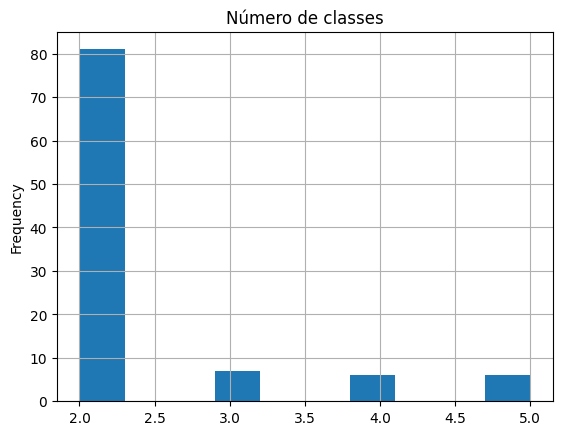

In [7]:
selected_datasets.NumberOfClasses.plot(kind='hist', grid=True, title='Número de classes')

## Análise de Rótulos

In [8]:
def gen_metabase(metabase_files):
    
    df_list= [pd.read_csv(f) for f in metabase_files]
    metabase = pd.concat(df_list, join='inner')
    metabase.dataset_id = metabase.dataset_id.astype(int)

    return metabase
    

In [9]:
def gen_heatmap(metabase, title):

    heatmap = dict()
    
    for k, group in metabase.groupby('dataset_id'):
        heatmap[k] = group.best_strategy
        
    df = pd.DataFrame(heatmap)
    df.fillna('NaN', inplace=True)
    
    value_to_int = {j:i for i, j in enumerate(sorted(pd.unique(df.values.ravel()),reverse=True))}
    cmap = sns.color_palette(n_colors=len(value_to_int))
    
    fig, ax = plt.subplots(figsize=(20,20))  
    sns.heatmap(df.replace(value_to_int).T, cmap=cmap, linewidth=.1, ax=ax)
    
    colorbar = ax.collections[0].colorbar 
    n = len(value_to_int)
    r = colorbar.vmax - colorbar.vmin 
    colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
    colorbar.set_ticklabels(list(value_to_int.keys()))
    
    ax.set_title(title)

In [10]:
def counts_per_dataset(metabase):
    
    heatmap = dict()
    for k, group in metabase.groupby('dataset_id'):
        heatmap[k] = group.best_strategy

    df = pd.DataFrame(heatmap)
    df.fillna('NaN', inplace=True)
    
    counts_df = df.apply(pd.value_counts)
    counts_df = counts_df.drop(index=['NaN']).fillna(0).transform(lambda x: x.div(sum(x))).T

    return counts_df

### KNN

In [11]:
knn_files = !find $METABASE_PATH -type f | grep 'KNeighborsClassifier.\csv'

In [12]:
knn_metabase = gen_metabase(knn_files)
print(knn_metabase.shape, len(knn_metabase.groupby('dataset_id')), 'bases')

(7810, 76) 100 bases


In [13]:
counts_per_dataset(knn_metabase).describe()

,consensus_entropy_sampling,entropy_sampling,margin_sampling,max_disagreement_sampling,uncertainty_batch_sampling,uncertainty_sampling,vote_entropy_sampling
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.059419,0.079898,0.114953,0.151714,0.155016,0.352761,0.086239
std,0.047074,0.049394,0.055647,0.103731,0.109985,0.210426,0.074466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000
25%,0.025481,0.040000,0.076681,0.071429,0.080000,0.218571,0.038105
50%,0.050000,0.080000,0.119322,0.142857,0.133845,0.285000,0.071429
75%,0.080000,0.120000,0.140714,0.190000,0.220000,0.452500,0.113333
max,0.214286,0.235294,0.260000,0.481481,0.620000,0.987952,0.500000


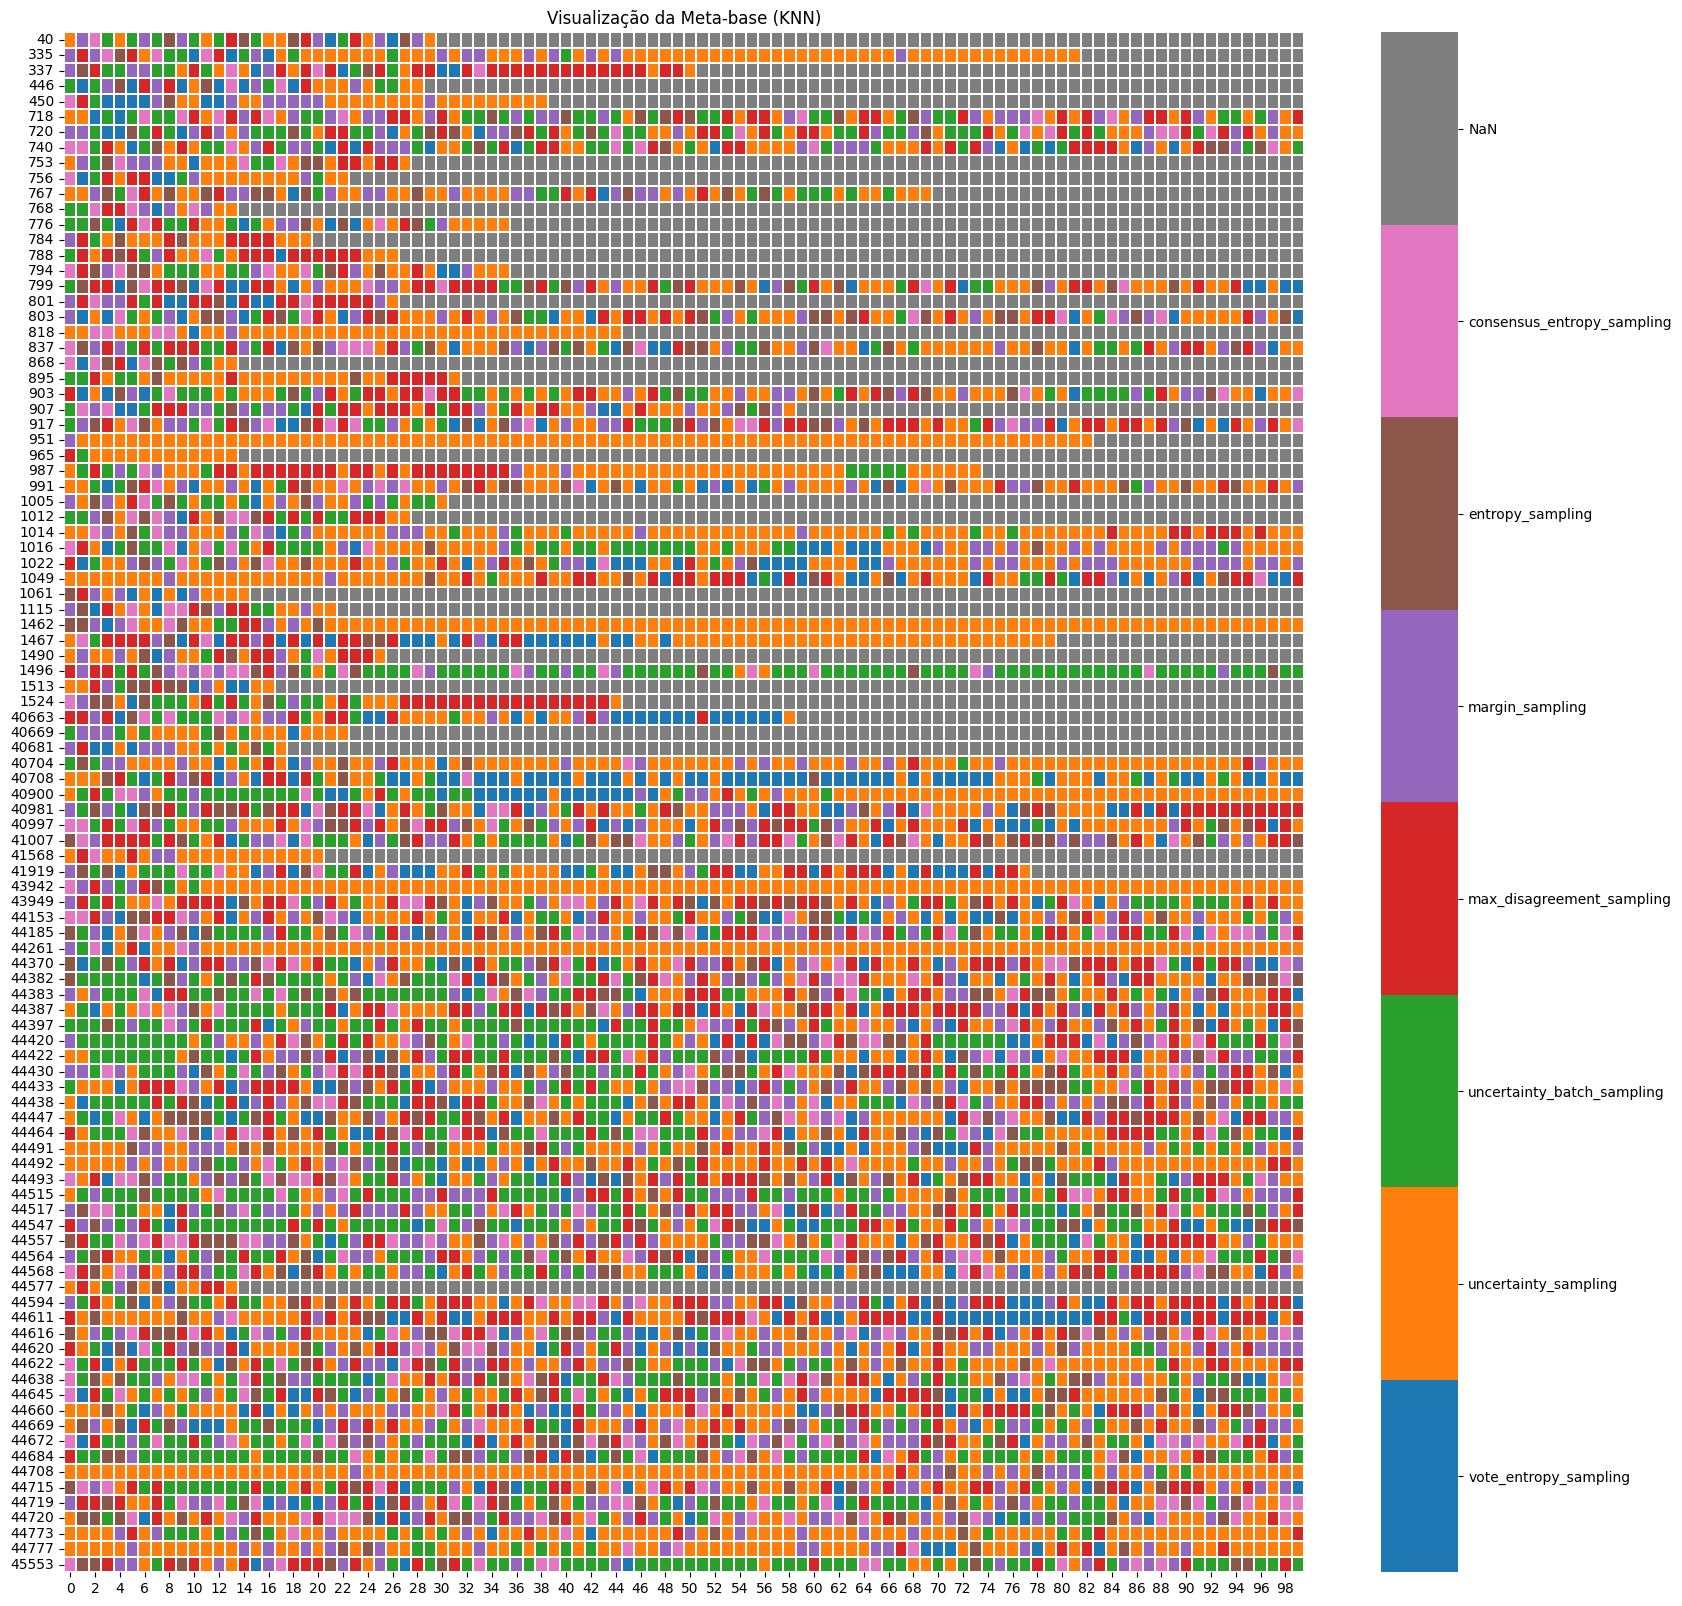

In [14]:
gen_heatmap(knn_metabase, 'Visualização da Meta-base (KNN)')

In [24]:
knn_metabase[['best_strategy']].apply(pd.value_counts).transform(lambda x: x.div(sum(x)))

,best_strategy
best_strategy,
uncertainty_sampling,0.343918
uncertainty_batch_sampling,0.165429
max_disagreement_sampling,0.147759
margin_sampling,0.115365
vote_entropy_sampling,0.086044
entropy_sampling,0.080922
consensus_entropy_sampling,0.060563


### SVM

In [25]:
svm_files = !find $METABASE_PATH -type f | grep 'SVC\.csv'

In [26]:
svm_metabase = gen_metabase(svm_files)

In [27]:
svm_metabase.shape

(7810, 76)

In [28]:
counts_per_dataset(svm_metabase).describe()

,consensus_entropy_sampling,entropy_sampling,margin_sampling,max_disagreement_sampling,uncertainty_batch_sampling,uncertainty_sampling,vote_entropy_sampling
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.100993,0.079883,0.095713,0.240803,0.078393,0.300038,0.104176
std,0.084289,0.075263,0.082801,0.211729,0.073862,0.280639,0.084317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030000,0.010000,0.030000,0.098810,0.010000,0.120000,0.042609
50%,0.082169,0.067816,0.083478,0.170000,0.066667,0.195000,0.092619
75%,0.160000,0.130109,0.142857,0.330743,0.130000,0.389167,0.150000
max,0.333333,0.290000,0.428571,0.950000,0.420000,1.000000,0.360000


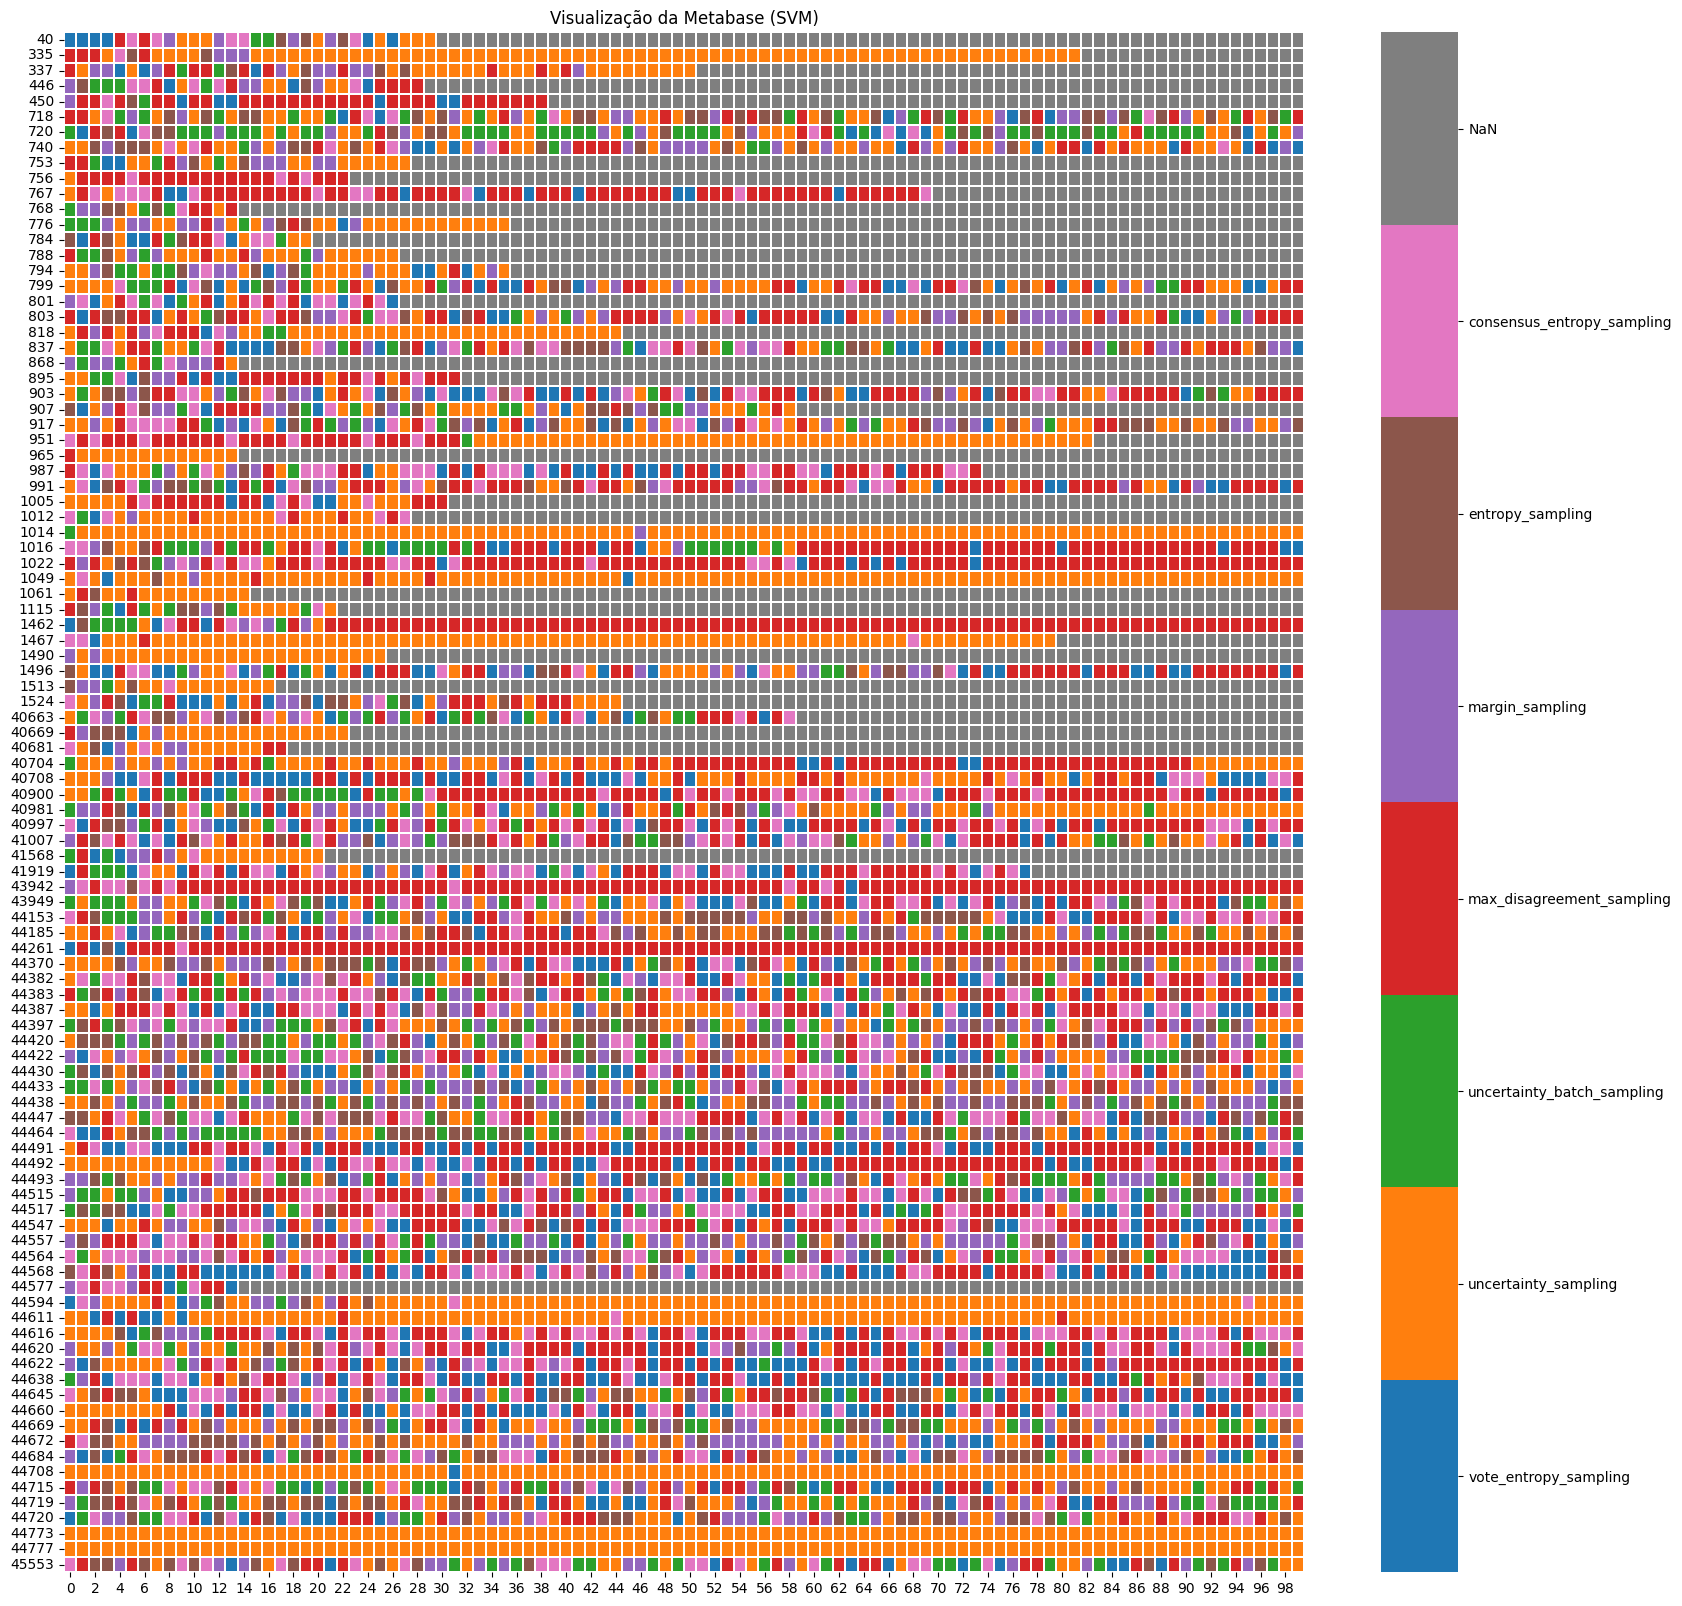

In [29]:
gen_heatmap(svm_metabase, 'Visualização da Metabase (SVM)')

In [30]:
svm_metabase[['best_strategy']].apply(pd.value_counts).transform(lambda x: x.div(sum(x)))

,best_strategy
best_strategy,
uncertainty_sampling,0.274520
max_disagreement_sampling,0.251472
vote_entropy_sampling,0.112292
consensus_entropy_sampling,0.104609
margin_sampling,0.092958
entropy_sampling,0.085403
uncertainty_batch_sampling,0.078745


### Random Forest

In [31]:
rf_files = !find $METABASE_PATH -type f | grep 'RandomForestClassifier\.csv'

In [32]:
rf_metabase = gen_metabase(rf_files)
rf_metabase.shape

(7810, 76)

In [33]:
counts_per_dataset(rf_metabase).describe()

,consensus_entropy_sampling,entropy_sampling,margin_sampling,max_disagreement_sampling,uncertainty_batch_sampling,uncertainty_sampling,vote_entropy_sampling
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.088121,0.125382,0.147785,0.110556,0.106064,0.325128,0.096964
std,0.057754,0.063575,0.072260,0.062582,0.057191,0.254185,0.058354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.000000
25%,0.043323,0.083736,0.110833,0.071071,0.071071,0.165000,0.059706
50%,0.089444,0.140000,0.150000,0.110000,0.110556,0.207564,0.090000
75%,0.130000,0.170000,0.195833,0.150000,0.142500,0.371154,0.137273
max,0.285714,0.240000,0.333333,0.282051,0.225806,0.987952,0.238095


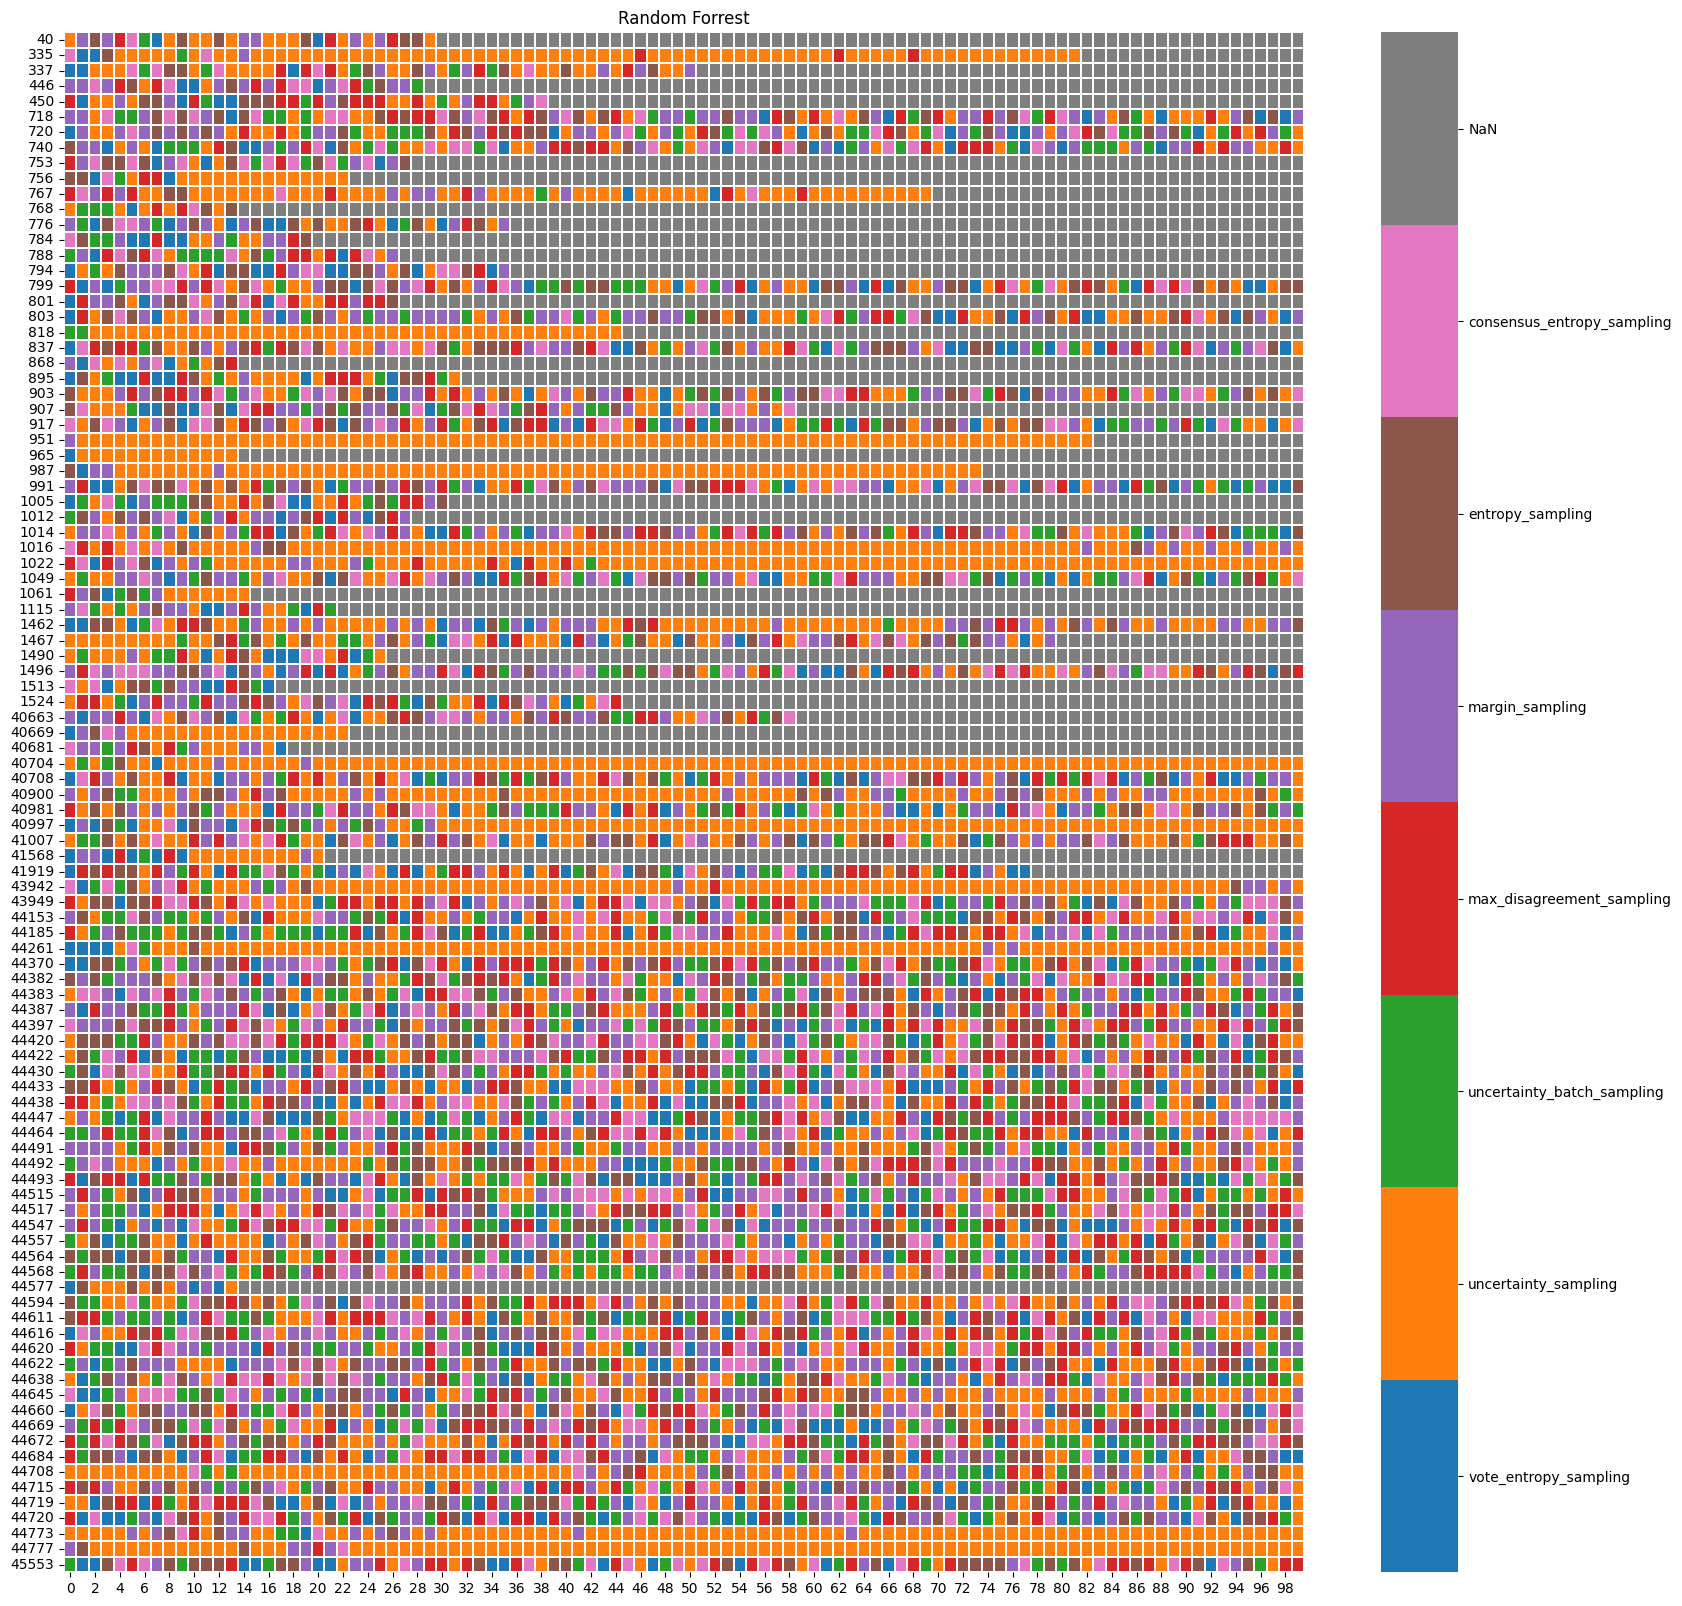

In [34]:
gen_heatmap(rf_metabase, 'Random Forrest')

In [35]:
rf_metabase[['best_strategy']].apply(pd.value_counts).transform(lambda x: x.div(sum(x)))

,best_strategy
best_strategy,
uncertainty_sampling,0.317286
margin_sampling,0.150704
entropy_sampling,0.127657
max_disagreement_sampling,0.112420
uncertainty_batch_sampling,0.109987
consensus_entropy_sampling,0.092190
vote_entropy_sampling,0.089757
